# Traffic sign detection

### Goal: detect traffic signs based on color segmentation and possibly shape

## import Libraries

In [39]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.layers import Conv2D , MaxPooling2D , AveragePooling2D , Flatten , Dense , Dropout , Activation , Concatenate , BatchNormalization , Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras import activations
import matplotlib.pyplot as plt
import pickle

%matplotlib inline


In [40]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Loading Data

In [41]:
df_train = pd.read_pickle('/gdrive/MyDrive/trafic/train.pickle')
df_valid = pd.read_pickle('/gdrive/MyDrive/trafic/valid.pickle')
df_test = pd.read_pickle('/gdrive/MyDrive/trafic/test.pickle')
labelnames = pd.read_csv('/gdrive/MyDrive/trafic/label_names.csv')
print('read files done')

read files done


In [42]:
type(df_train)

dict

In [43]:
trainx = df_train['features']
trainy = df_train['labels']
validx = df_valid['features']
validy = df_valid['labels']
testx = df_test['features']
testy = df_test['labels']
temptrainx = df_train['features']
temptrainy = df_train['labels']
print('data sprated')

data sprated


In [44]:
print('Train: X=%s , Y=%s'%(trainx.shape , trainy.shape))
print('Valid: X=%s , Y=%s'%(validx.shape , validy.shape))
print('Test: X=%s , Y=%s'%(testx.shape , testy.shape))

Train: X=(34799, 32, 32, 3) , Y=(34799,)
Valid: X=(4410, 32, 32, 3) , Y=(4410,)
Test: X=(12630, 32, 32, 3) , Y=(12630,)


In [45]:
#one hot encoding
trainy = to_categorical(trainy)
validy = to_categorical(validy)
testy = to_categorical(testy)
print('one hot encoding done')

one hot encoding done


In [46]:
print('Before scaling:')
print('Train min:', trainx.min(), 'max:', trainx.max())
print('Valid min:', validx.min(), 'max:', validx.max())
print('Test min:', testx.min(), 'max:', testx.max())

Before scaling:
Train min: 0 max: 255
Valid min: 0 max: 255
Test min: 0 max: 255


In [47]:
trainx = trainx.astype('float32')
validx = validx.astype('float32')
testx = testx.astype('float32')
trainx = trainx/255.0
validx = validx/255.0
testx = testx/255.0
print('data types to float and into[0,1]')

data types to float and into[0,1]


## Image augmentation

In [48]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10 ,
    zoom_range = 0.1 ,
    width_shift_range = 0.1 ,
    height_shift_range = 0.1 ,
    horizontal_flip =False ,
    vertical_flip = False
)
print('imagedatagenerator defined')

imagedatagenerator defined


In [49]:
#creating a generator
imagedata = datagen.flow(trainx , y = trainy , batch_size=128)
for i, (images,labels) in enumerate(imagedata):
  print(i)
  if i==0 :
    print(images.shape)
    break

0
(128, 32, 32, 3)


In [50]:
datagentest = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15 ,
    zoom_range = 0.4 ,
    width_shift_range = 0.3 ,
    height_shift_range = 0.1 ,
    horizontal_flip =False ,
    vertical_flip = False
)
print('imagedatagenerator defined for test')

imagedatagenerator defined for test


0
(1, 32, 32, 3)
(32, 32, 3)
(32, 32, 3)


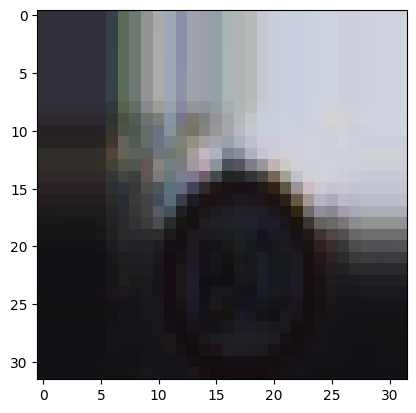

In [51]:
#Visualize how each image looks after augmentation.
imagedata = datagentest.flow(trainx,batch_size=1)
for i,(images) in enumerate(imagedata):
  print(i)
  if i==0:
    print(images.shape)
    print(images[0].shape)
    img = images[0].reshape(32,32,3) # reshaping to ensure it's in the correct shape
    print(img.shape)
    plt.imshow(img)
    break

0
(1, 32, 32, 3)
(32, 32, 3)
(32, 32, 3)


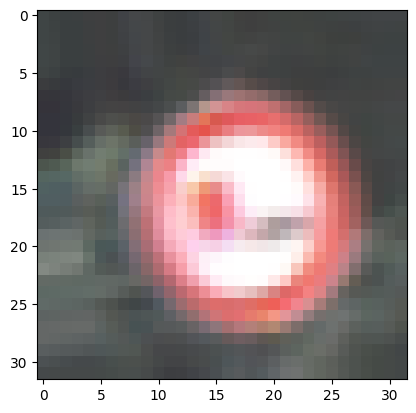

In [52]:
imagedata = datagen.flow(trainx,y = trainy,batch_size=1)
for i,(images,labels) in enumerate(imagedata):
  print(i)
  if i==0:
    print(images.shape)
    img = images[0]
    print(img.shape)
    img = img.reshape(32,32,3)
    print(img.shape)
    plt.imshow(img)
    break

In [53]:
batch_size = 256
trianingdata = datagen.flow(trainx,y=trainy,batch_size=batch_size)
validdata = datagen.flow(validx,y=validy,batch_size=batch_size)
testdata = datagen.flow(testx , y = testy , batch_size = batch_size)
print('data ready for cnn')

data ready for cnn


In [54]:
es = EarlyStopping(monitor='val_loss',mode='auto',verbose=1,patience=1)
checkpointer = ModelCheckpoint(filepath="best_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True)
print('earlystopping , checkpointer defined')

earlystopping , checkpointer defined


## Defining the model

In [55]:
inputmodel=Input((trainx.shape[1],trainx.shape[2],trainx.shape[3]),name='input_layer')

model1=Conv2D(32,(5,5),activation='relu',name='Conv1_5')(inputmodel) # 32 filters (size 5x5)
model1=BatchNormalization(name='Bnorml')(model1)
model1=Conv2D(32,(5,5),activation='relu',padding='same',name='Conv2_5')(model1)
model1=BatchNormalization(name='Bnorm2')(model1)
model1=MaxPooling2D((2,2),name='Maxpool1')(model1)
model1=Conv2D(64,(3,3),activation='relu',padding='same',name='Conv3_3')(model1)
model1=BatchNormalization(name='Bnorm3')(model1)
model1=Conv2D(64,(3,3),activation='relu',padding='same',name='Conv4_3')(model1)
model1=BatchNormalization(name='Bnorm4')(model1)
model1=AveragePooling2D((2,2),name='Avgpool1')(model1)
model1=Conv2D(128,(1,1),activation='relu',padding='valid',name='Conv5_1')(model1)
model1=BatchNormalization(name='Bnorm5')(model1)

model1=Flatten(name='Flatten')(model1)

model1=Dense(units=32,activation='relu')(model1)
model=Dropout(rate=0.2)(model1)
model1=BatchNormalization()(model1)
model1=Dense(units=20,activation='relu')(model1)
model1=BatchNormalization()(model1)
model1=Dense(units=15,activation='relu')(model1)
model1=BatchNormalization()(model1)
output=Dense(units=43,activation='softmax',name='preds')(model1)

model = Model(inputs = [inputmodel],outputs=[output])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1_5 (Conv2D)                │ (None, 28, 28, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bnorml (BatchNormalization)     │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2_5 (Conv2D)                │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bnorm2 (BatchNormalization)     │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Maxpool1 (MaxPooling2D)         │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3_3 (Conv2D)                │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bnorm3 (BatchNormalization)     │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4_3 (Conv2D)                │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bnorm4 (BatchNormalization)     │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Avgpool1 (AveragePooling2D)     │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5_1 (Conv2D)                │ (None, 7, 7, 128)      │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bnorm5 (BatchNormalization)     │ (None, 7, 7, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       200,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 43)             │           688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295,755 (1.13 MB)

 Trainable params: 294,981 (1.13 MB)

 Non-trainable params: 774 (3.02 KB)

In [56]:
sgd = SGD(learning_rate=0.005,momentum=0.9)
model.compile(optimizer=sgd , loss='categorical_crossentropy',metrics=['accuracy'])
print('optimizer defined')

optimizer defined


In [57]:
history = model.fit(trianingdata,
                    epochs=15,
                    validation_data=validdata,
                    verbose=1,
                    callbacks=[es, checkpointer])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.1530 - loss: 3.4109
Epoch 1: val_accuracy improved from -inf to 0.09977, saving model to best_weights.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 39s 211ms/step - accuracy: 0.1537 - loss: 3.4082 - val_accuracy: 0.0998 - val_loss: 3.5551
Epoch 2/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4435 - loss: 2.1925
Epoch 2: val_accuracy improved from 0.09977 to 0.24694, saving model to best_weights.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 0.4438 - loss: 2.1909 - val_accuracy: 0.2469 - val_loss: 2.9732
Epoch 3/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6416 - loss: 1.3830
Epoch 3: val_accuracy improved from 0.24694 to 0.59229, saving model to best_weights.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.6419 - loss: 1.3819 - val_accuracy: 0.5923 - val_loss: 1.4833
Epoch 4/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7865 - loss: 0.8593
Epoch 4: val_accuracy improved from 0.59229 to 0.71655, saving model to best_weights.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.7867 - loss: 0.8587 - val_accuracy: 0.7166 - val_loss: 1.0175
Epoch 5/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8653 - loss: 0.5551
Epoch 5: val_accuracy improved from 0.71655 to 0.80794, saving model to best_weights.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.8654 - loss: 0.5548 - val_accuracy: 0.8079 - val_loss: 0.6946
Epoch 6/15
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9143 - loss: 0.3685
Epoch 6: val_accuracy did not improve from 0.80794
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.9144 - loss: 0.3682 - val_accuracy: 0.7866 - val_loss: 0.6956
Epoch 6: early stopping


In [58]:
model.save_weights("/gdrive/My Drive/weights.weights.h5")
print('model saved')

model saved


## ploting results

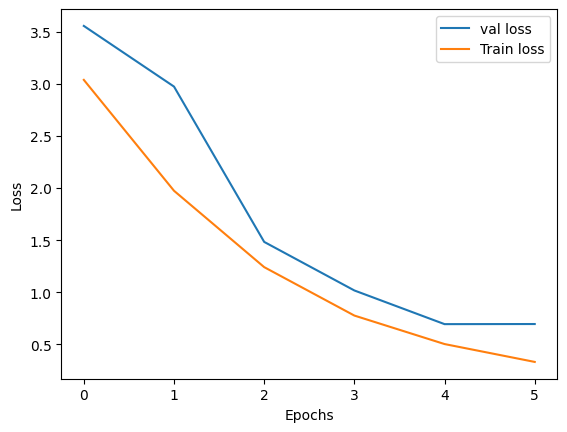

In [59]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['val loss','Train loss'],loc = 'upper right')
plt.savefig('plot_loss.png')
plt.show()

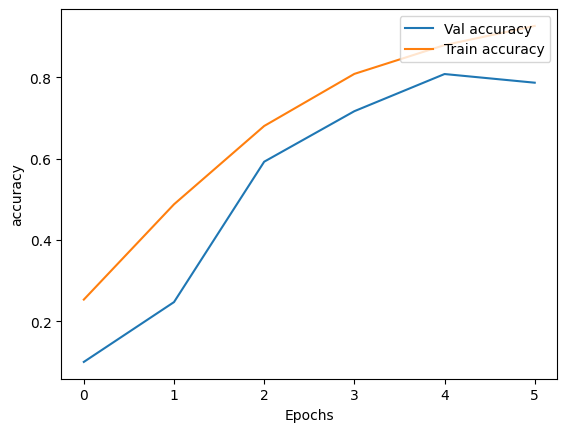

In [60]:
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']

plt.plot(val_accuracy)
plt.plot(accuracy)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Val accuracy','Train accuracy'],loc='upper right')
plt.savefig('plot_accuracy.png')
plt.show()

In [61]:
# Predict the labels for the test set
predicty = model.predict(testx)
predicty = np.argmax(predicty, axis=1)
temptesty = df_test['labels']

correct_predictions = np.sum(predicty == temptesty)
accuracy = correct_predictions / len(predicty)
print(f"Accuracy: {accuracy * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(32, 32, 32, 3))
  warnings.warn(msg)


395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Accuracy: 87.01%


In [64]:
import cv2
def convert_to_grayscale(images):
    return np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images])

# Convert training images to grayscale
graytrain = convert_to_grayscale(trainx)
print(f'Converted {len(trainx)} training images to grayscale.')

# Convert validation images to grayscale
grayvalid = convert_to_grayscale(validx)
print(f'Converted {len(validx)} validation images to grayscale.')

Converted 34799 training images to grayscale.
Converted 4410 validation images to grayscale.


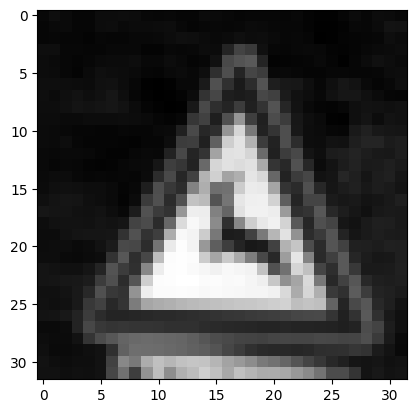

In [65]:
plt.imshow(graytrain[500],cmap='gray')

In [66]:
graytrain = graytrain.reshape(-1,32,32,1)
trianinggraydata = datagen.flow(graytrain,y=trainy,batch_size=batch_size)
grayvalid = grayvalid.reshape(-1,32,32,1)
validgraydata = datagen.flow(grayvalid,y=validy,batch_size=batch_size)

In [67]:
esgray = EarlyStopping(monitor='val_loss',mode='auto',verbose=1,patience=1)
checkpointergray = ModelCheckpoint(filepath="best_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True)

In [68]:
inputmodel = Input((graytrain.shape[1], graytrain.shape[2], graytrain.shape[3]), name='input_layer')

# Convolutional Layer 1
model2 = Conv2D(32, (5, 5), activation='relu', name='Conv1_5')(inputmodel)  # 32 filters (size 5x5)
model2 = BatchNormalization(name='Bnorm1')(model2)
model2 = Conv2D(32, (5, 5), activation='relu', padding='same', name='Conv2_5')(model2)
model2 = BatchNormalization(name='Bnorm2')(model2)
model2 = MaxPooling2D((2, 2), name='Maxpool1')(model2)

model2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv3_3')(model2)
model2 = BatchNormalization(name='Bnorm3')(model2)
model2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv4_3')(model2)
model2 = BatchNormalization(name='Bnorm4')(model2)
model2 = AveragePooling2D((2, 2), name='Avgpool1')(model2)

model2 = Conv2D(128, (1, 1), activation='relu', padding='valid', name='Conv5_1')(model2)
model2 = BatchNormalization(name='Bnorm5')(model2)

# Flatten layer
model2 = Flatten(name='Flatten')(model2)

# Fully connected layers
model2 = Dense(units=32, activation='relu')(model2)
model2 = Dropout(rate=0.2)(model2)
model2 = BatchNormalization()(model2)
model2 = Dense(units=20, activation='relu')(model2)
model2 = BatchNormalization()(model2)
model2 = Dense(units=15, activation='relu')(model2)
model2 = BatchNormalization()(model2)

output = Dense(units=43, activation='softmax', name='preds')(model2)

model2 = Model(inputs=[inputmodel], outputs=[output])

# Display the model summary
model2.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1_5 (Conv2D)                │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bnorm1 (BatchNormalization)     │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2_5 (Conv2D)                │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bnorm2 (BatchNormalization)     │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Maxpool1 (MaxPooling2D)         │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3_3 (Conv2D)                │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bnorm3 (BatchNormalization)     │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4_3 (Conv2D)                │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bnorm4 (BatchNormalization)     │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Avgpool1 (AveragePooling2D)     │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5_1 (Conv2D)                │ (None, 7, 7, 128)      │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bnorm5 (BatchNormalization)     │ (None, 7, 7, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │       200,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 43)             │           688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 294,155 (1.12 MB)

 Trainable params: 293,381 (1.12 MB)

 Non-trainable params: 774 (3.02 KB)

In [69]:
sgd = SGD(learning_rate=0.02,momentum=0.9)
model2.compile(optimizer=sgd , loss='categorical_crossentropy',metrics=['accuracy'])
print('optimizer defined')

optimizer defined


In [70]:
history = model2.fit(trianinggraydata,
                              validation_data = validgraydata,
                              epochs=10,
                              verbose=1,
                              callbacks=[esgray,checkpointergray])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(None, 32, 32, 1))
  warnings.warn(msg)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.1372 - loss: 3.4250
Epoch 1: val_accuracy improved from -inf to 0.09002, saving model to best_weights.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - accuracy: 0.1380 - loss: 3.4213 - val_accuracy: 0.0900 - val_loss: 3.8493
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5044 - loss: 1.7368
Epoch 2: val_accuracy improved from 0.09002 to 0.42540, saving model to best_weights.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 33s 101ms/step - accuracy: 0.5049 - loss: 1.7349 - val_accuracy: 0.4254 - val_loss: 2.1107
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7358 - loss: 0.9217
Epoch 3: val_accuracy improved from 0.42540 to 0.76576, saving model to best_weights.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.7361 - loss: 0.9208 - val_accuracy: 0.7658 - val_loss: 0.8181
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8526 - loss: 0.5093
Epoch 4: val_accuracy improved from 0.76576 to 0.85306, saving model to best_weights.h5


136/136 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.8527 - loss: 0.5088 - val_accuracy: 0.8531 - val_loss: 0.4988
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9030 - loss: 0.3236
Epoch 5: val_accuracy did not improve from 0.85306
136/136 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9031 - loss: 0.3235 - val_accuracy: 0.7961 - val_loss: 0.7399
Epoch 5: early stopping


In [71]:
model2.save_weights("/gdrive/My Drive/weights6.weights.h5")
loss = history.history['loss']



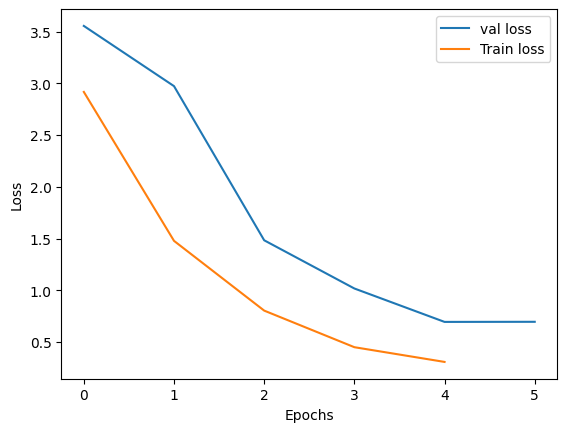

In [72]:
plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['val loss','Train loss'],loc = 'upper right')
plt.savefig('plot_loss.png')
plt.show()

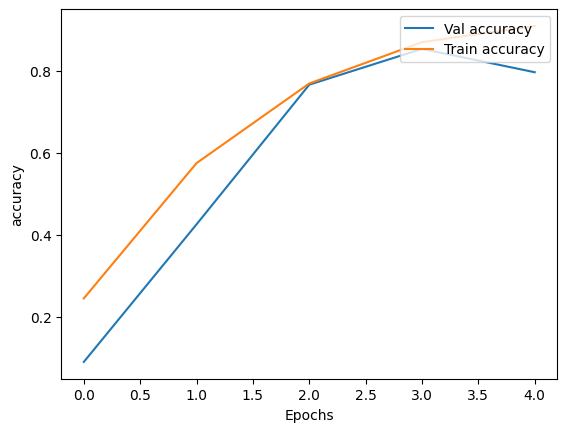

In [73]:
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']

plt.plot(val_accuracy)
plt.plot(accuracy)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Val accuracy','Train accuracy'],loc='upper right')
plt.savefig('plot_accuracy.png')
plt.show()

In [75]:
# Convert test images to grayscale
graytest = convert_to_grayscale(testx)
print(f'Converted {len(testx)} test images to grayscale.')
graytest = graytest.reshape(-1, 32, 32, 1)

# Evaluate the model on the grayscale test data
test_loss, test_acc = model2.evaluate(graytest, testy, verbose=1)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Converted 12630 test images to grayscale.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(None, 32, 32, 1))
  warnings.warn(msg)


395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8716 - loss: 0.5496
Test Accuracy: 87.19%


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(32, 32, 32, 1))
  warnings.warn(msg)


389/395 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(None, 32, 32, 1))
  warnings.warn(msg)


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


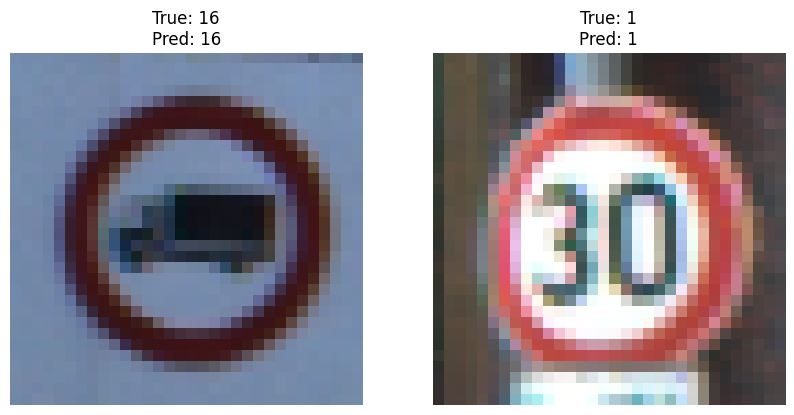

In [77]:
predictions = model2.predict(graytest)
predicted_labels = np.argmax(predictions, axis=1)

example_indices = [0, 1]  # Plot the first two examples

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, idx in enumerate(example_indices):
    # Extract the image and true label
    img = testx[idx]
    true_label = testy[idx]
    predicted_label = predicted_labels[idx]
    img = img.reshape(32, 32, 3)
    axes[i].imshow(img)
    axes[i].axis('off')
    true_label_class = np.argmax(true_label)
    axes[i].set_title(f'True: {true_label_class}\nPred: {predicted_label}')

plt.show()